# Heat Wave and Cold Spells

Dieses Skript verarbeitet den Datensatz "Heat Wave Days" aus dem Copernics Climate Data Store. Der Datensatz enthält die Anzahl der Hitzewellen-Tage (Heat wave days; HWD), die mit verschiedenen europaweiten sowie nationalen/regionalen Definitionen im Rahmen des C3S European Health Service entwickelt wurden. Diese Tage sind für unterschiedliche zukünftige Zeiträume und Klimawandelszenarien verfügbar.

**Informationen zum Datensatz**: 

* Source: [Heat Wave and Cold Spells](https://cds.climate.copernicus.eu/datasets/sis-heat-and-cold-spells?tab=overview)
* Author: T. Tewes (Stadt Konstanz) 
* Notebook-Version: 1.2 (Aktualisiert: März 05, 2024)

## 1. Festlegen der Pfade und Arbeitsverzeichnisse

In [1]:
import os

''' ---- Verzeichnisse hier angeben ---- '''
download_folder = r".\data\sis-heat-and-cold-spells\download"
working_folder = r".\data\sis-heat-and-cold-spells\working"
geotiff_folder = r".\data\sis-heat-and-cold-spells\geotiff"
csv_folder = r".\data\sis-heat-and-cold-spells\csv"
output_folder = r".\data\sis-heat-and-cold-spells\output"
''' ----- Ende der Angaben ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Herunterladen und Entpacken des Datensatzes

### 2.1 Authentifizierung

In [2]:
import cdsapi

def main():
    # API-Key für die Authentifizierung
    api_key = "fdae60fd-35d4-436f-825c-c63fedab94a4"
    api_url = "https://cds.climate.copernicus.eu/api"

    # Erstellung des CDS-API-Clients
    client = cdsapi.Client(url=api_url, key=api_key)
    return client

### 2.2 Definieren Sie die „request“ und laden Sie den Datensatz herunter

In [3]:
# Definieren der Begrenzungsrahmen-Koordinaten (WGS84-Format)
# Das Koordinatenformat lautet: [Norden, Westen, Süden, Osten]
bbox_wgs84_deutschland = [56.0, 5.8, 47.2, 15.0]
bbox_wgs84_de_standard = [5.7, 47.1, 15.2, 55.2]
bbox_wgs84_konstanz = [47.9, 8.9, 47.6, 9.3]
bbox_wgs84_konstanz_standard = [9.0, 47.6, 9.3, 47.8]  # [West, South, East, North]

# Alternativ können Sie ein Shapefile für eine präzise geografische Filterung verwenden
import geopandas as gpd
import math

# Beispiel: Shapefile von Konstanz laden (WGS84-Projektion)
de_shapefile = r"./shapefiles/de_boundary.shp"
de_gdf = gpd.read_file(de_shapefile)

# Extrahieren Sie den Begrenzungsrahmen des Shapefiles
de_bounds = de_gdf.total_bounds

# Passen Sie den Begrenzungsrahmen an und puffern Sie ihn, um einen etwas größeren
de_bounds_adjusted = [(math.floor(de_bounds[0]* 10)/10)-0.1,
                      (math.floor(de_bounds[1]* 10)/10)-0.1,
                      (math.ceil(de_bounds[2]* 10)/10)+0.1,
                      (math.ceil(de_bounds[3]* 10)/10)+0.1]

# Ordnen Sie die Koordinaten in das Format: [Nord, West, Süd, Ost] um.
bbox_de_bounds_adjusted = [de_bounds_adjusted[3], de_bounds_adjusted[0],
                           de_bounds_adjusted[1], de_bounds_adjusted[2]]

In [4]:
# Der Datensatz sis-heat-and-cold-spells ermöglicht die Auswahl zwischen zwei Variablen:
# "Heat wave days" and "Cold spell days".
# Abhängig von der gewählten Variablen variieren die Definitionsoptionen.
# Für "heat_wave_days" sind alle Definitionen verfügbar.
# Für "cold_spell_days" wird nur die 'landesspezifische' Definition unterstützt.

variable_to_definition_map = {
    'heat_wave_days': ['climatological_related', 'health_related', 'country_related'],
    'cold_spell_days': ['country_related']
}

# Ausgewählte Variable
selected_variable = 'heat_wave_days'

# Abrufen der entsprechenden Definitionen basierend auf der ausgewählten Variablen
selected_definition = variable_to_definition_map.get(selected_variable, [])

# Ausgabe der ausgewählten Definitionen und der Variable
print(f"ausgewählte_variable: {selected_variable}\nausgewählte_definition: {selected_definition}")

ausgewählte_variable: heat_wave_days
ausgewählte_definition: ['climatological_related', 'health_related', 'country_related']


In [5]:
# Definition des Datensatzes und der Request-Parameter
dataset = "sis-heat-and-cold-spells"
request = {
    "variable": selected_variable,
    "definition": selected_definition,
    "experiment": [
        "rcp4_5",
        "rcp8_5"
    ],
    "ensemble_statistic": [
        "ensemble_members_average",
        "ensemble_members_standard_deviation"
    ],
    "area": bbox_de_bounds_adjusted
}

In [6]:
# Führen Sie es aus, um den Datensatz herunterzuladen:
def main_retrieve():
    dataset_filename = f"{dataset}-{selected_definition}.zip"
    dataset_filepath = os.path.join(download_folder, dataset_filename)

    # Den Datensatz nur herunterladen, wenn er noch nicht heruntergeladen wurde
    if not os.path.isfile(dataset_filepath):
        # Rufen Sie den CDS-Client nur auf, wenn der Datensatz noch nicht heruntergeladen wurde.
        client = main()
        # Den Datensatz mit den definierten Anforderungsparametern herunterladen
        client.retrieve(dataset, request, dataset_filepath)
    else:
        print("Datensatz bereits heruntergeladen.")

if __name__ == "__main__":
    main_retrieve()

Datensatz bereits heruntergeladen.


### 2.3 Extrahieren die ZIP-Datei in Ordner

In [7]:
import zipfile

# Definieren Sie einen Extraktionsordner für die ZIP-Datei, der dem Arbeitsordner entspricht
extract_folder = os.path.join(working_folder, f"{selected_variable}")
os.makedirs(extract_folder, exist_ok=True)

# Extract the zip file
try:
    if not os.listdir(extract_folder):
        dataset_filename = f"{dataset}-{selected_definition}.zip"
        dataset_filepath = os.path.join(download_folder, dataset_filename)
        
        with zipfile.ZipFile(dataset_filepath, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
            print(f"Dateien erfolgreich extrahiert nach: {extract_folder}")
    else:
        print("Ordner ist nicht leer. Entpacken überspringen.")
except FileNotFoundError:
    print(f"Fehler: Die Datei {dataset_filepath} wurde nicht gefunden.")
except zipfile.BadZipFile:
    print(f"Fehler: Die Datei {dataset_filepath} ist keine gültige ZIP-Datei.")
except Exception as e:
    print(f"Ein unerwarteter Fehler ist aufgetreten: {e}")

Ordner ist nicht leer. Entpacken überspringen.


## 3. Untersuchen der Metadaten der NetCDF4-Datei

⚠️ <span style="background-color: red; color: white; padding: 2px 4px;">Wichtig</span>: Obwohl alle Datensätze zum Download verfügbar sind, konzentriert sich dieses Notebook auf die Analyse der folgenden Auswahl:
* selected_variable = 'heat_wave_days'
* selected_definition = 'climatological related'


In [8]:
# Variable und Definition definieren
selected_variable = 'heat_wave_days'
selected_definition = 'climatological_related'

### 3.1 Erstellen eines DataFrame mit verfügbaren NetCDF-Dateien

In [9]:
import re
import pandas as pd
import netCDF4 as nc

def meta(filename):
    # Überprüfen, ob der Dateiname dem erwarteten Muster entspricht
    match = re.search(r"(?P<ds_variable>\w+?)_(?P<ds_definition>\w+?)_(?P<rcp>rcp\d+?)_(?P<rcp_statistic>mean|stdev)_v(\d+\.\d+)\.", filename)
    
    # Fehler ausgeben, wenn der Dateiname nicht dem erwarteten Schema entspricht
    if not match:
        match = re.search("Der angegebene Dateiname entspricht nicht dem erwarteten Benennungsschema.")
    
    # Funktion zum Extrahieren des Variablennamens aus der NetCDF-Datei
    def get_nc_variable():
        with nc.Dataset(os.path.join(extract_folder, filename), 'r') as nc_dataset:
            nc_variable_name = nc_dataset.variables.keys()
            return [*nc_variable_name][0]
    
    # Metadaten als Dictionary zurückgeben
    return dict(
        filename=filename,
        path=os.path.join(extract_folder, filename),
        ds_variable=match.group('ds_variable'),
        ds_definition=match.group('ds_definition'),
        variable_name=get_nc_variable(),
        rcp=match.group('rcp'),
        rcp_statistic=match.group('rcp_statistic')
    )

# Metadaten für alle NetCDF-Dateien im Ordner extrahieren
# Das Dictionary 'nc_files' enthält alle relevanten Metadaten der verfügbaren NetCDF4-Dateien
# Dieses Dictionary wird später verwendet, um die Dateien in GeoTiff zu konvertieren
nc_files = [meta(f) for f in os.listdir(extract_folder) if f.endswith('.nc')]
df_nc_files = pd.DataFrame.from_dict(nc_files)

# Pandas-Anzeigeoptionen anpassen
pd.options.display.max_colwidth = 24

# DataFrame anzeigen, ohne die Spalte 'path' darzustellen
df_nc_files.loc[:, df_nc_files.columns != 'path']

,filename,ds_variable,ds_definition,variable_name,rcp,rcp_statistic
0,HWD_EU_climate_rcp45...,HWD,EU_climate,HWD_EU_climate,rcp45,mean
1,HWD_EU_climate_rcp45...,HWD,EU_climate,HWD_EU_climate,rcp45,stdev
2,HWD_EU_climate_rcp85...,HWD,EU_climate,HWD_EU_climate,rcp85,mean
3,HWD_EU_climate_rcp85...,HWD,EU_climate,HWD_EU_climate,rcp85,stdev
4,HWD_EU_health_rcp45_...,HWD,EU_health,HWD_EU_health,rcp45,mean
5,HWD_EU_health_rcp45_...,HWD,EU_health,HWD_EU_health,rcp45,stdev
6,HWD_EU_health_rcp85_...,HWD,EU_health,HWD_EU_health,rcp85,mean
7,HWD_EU_health_rcp85_...,HWD,EU_health,HWD_EU_health,rcp85,stdev
8,HWD_national_rcp45_m...,HWD,national,HWD_merged,rcp45,mean
9,HWD_national_rcp45_s...,HWD,national,HWD_merged,rcp45,stdev


### 3.2 Einzigartige Variablennamen und verfügbare Variablen ausgeben

In [10]:
# Variable definieren, um bereits verarbeitete Variablennamen zu speichern und Duplikate zu vermeiden  
seen_variables = set()

# Alle Variablen in jeder NetCDF-Datei auflisten  
for i, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable_name']
    
    # Überspringen, wenn die Variable bereits verarbeitet wurde  
    if variable_name in seen_variables:
        continue

    # NetCDF-Datei im Lesemodus öffnen  
    with nc.Dataset(nc_file['path'], mode='r') as nc_dataset:  
        # Alle Variablen im aktuellen Datensatz auflisten  
        variables_list = list(nc_dataset.variables.keys())  
        
        # Details der Datei und ihrer Variablen ausgeben  
        print(f"{i + 1:<2} {variable_name:<18}: Verfügbare Variablen: {variables_list}") 
    
    # Diese Variable als verarbeitet markieren  
    seen_variables.add(variable_name)

1  HWD_EU_climate    : Verfügbare Variablen: ['HWD_EU_climate', 'height', 'quantile', 'lat', 'lon', 'time']
5  HWD_EU_health     : Verfügbare Variablen: ['HWD_EU_health', 'height', 'lat', 'lon', 'time']
9  HWD_merged        : Verfügbare Variablen: ['HWD_merged', 'height', 'lat', 'lon', 'time']


In [11]:
# Alle Variableninformationen in jeder NetCDF-Datei auflisten  
seen_variables = set()

# Alle variablen Informationen in jeder NetCDF-Datei auflisten
for i, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable_name']
    
    # Überspringen, wenn die Variable bereits verarbeitet wurde
    if variable_name in seen_variables:
        continue
    
    # NetCDF-Datei im Lesemodus öffnen
    with nc.Dataset(nc_file['path'], mode='r') as nc_dataset:  
        # Primärvariable-Daten abrufen  
        variable_data = nc_dataset[variable_name]  

        # Zusammenfassung der Primärvariable erstellen  
        summary = {  
            "Variablenname": variable_name,  
            "Datentyp": variable_data.dtype,  
            "Form": variable_data.shape,  
            "Variableninfo": f"{variable_data.dimensions}",  
            "Einheiten": getattr(variable_data, "units", "N/A"),  
            "Langer Name": getattr(variable_data, "long_name", "N/A"),  
        }  

        # Datensatz-Zusammenfassung als DataFrame zur besseren Visualisierung anzeigen  
        nc_summary = pd.DataFrame(list(summary.items()), columns=['Beschreibung', 'Bemerkungen'])  
        print(f"{i + 1}. Zusammenfassung der Variable '{variable_name}':")  
        display(nc_summary)  

    # Variablenname zur Liste der bereits verarbeiteten Variablen hinzufügen  
    seen_variables.add(variable_name)  

    # Ausgabe begrenzen  
    output_limit = 2  
    if len(seen_variables) >= output_limit:  
        print(f".... (Ausgabe auf die ersten {output_limit} Variablen gekürzt)")  
        break  

1. Zusammenfassung der Variable 'HWD_EU_climate':


,Beschreibung,Bemerkungen
0,Variablenname,HWD_EU_climate
1,Datentyp,float32
2,Form,"(100, 82, 95)"
3,Variableninfo,"('time', 'lat', 'lon')"
4,Einheiten,day
5,Langer Name,Ensemble members ave...


5. Zusammenfassung der Variable 'HWD_EU_health':


,Beschreibung,Bemerkungen
0,Variablenname,HWD_EU_health
1,Datentyp,float32
2,Form,"(100, 82, 95)"
3,Variableninfo,"('time', 'lat', 'lon')"
4,Einheiten,day
5,Langer Name,Ensemble members ave...


.... (Ausgabe auf die ersten 2 Variablen gekürzt)


## 4. Exportieren der NetCDF4-Dateien im CSV-Format

### 4.1 Definieren eine Funktion zum Konvertieren von NetCDF-Daten in DataFrame

In [12]:
import xarray as xr

# Funktion zur Konvertierung von NetCDF-Daten in ein Pandas DataFrame
def netcdf_to_dataframe(
    nc_file,
    bounding_box=None):

    # Öffne das NetCDF-Dataset im Lesemodus
    with xr.open_dataset(nc_file['path']) as nc_dataset:
        # Zugriff auf die Variablendaten aus dem Datensatz
        variable_data = nc_dataset[nc_file['variable_name']]

        # Sicherstellen, dass die Namen für Breiten- und Längengrad korrekt sind
        latitude_name = 'latitude' if 'latitude' in nc_dataset.coords else 'lat'
        longitude_name = 'longitude' if 'longitude' in nc_dataset.coords else 'lon'
        
        # Falls eine Begrenzungsbox angegeben ist, die Daten filtern
        if bounding_box:
            filtered_data = variable_data.where(
                (nc_dataset[latitude_name] >= bounding_box[1]) & (nc_dataset[latitude_name] <= bounding_box[3]) &
                (nc_dataset[longitude_name] >= bounding_box[0]) & (nc_dataset[longitude_name] <= bounding_box[2]),
                drop=True
            )
        else:
            filtered_data = variable_data

        # Umwandlung des xarray-Datensatzes in ein Pandas DataFrame
        df = filtered_data.to_dataframe().reset_index().set_index(['time', latitude_name, longitude_name])

        variable_column_name = f"{nc_file['variable_name']}_{nc_file['rcp']}_{nc_file['rcp_statistic']}"
        df.rename(columns={nc_file['variable_name']: variable_column_name}, inplace=True)

        # Entfernen nicht benötigter Spalten (variiert je nach Datensatz)
        if 'height' in df.columns:
            df = df.drop(columns=['height'])
        if 'quantile' in df.columns:
            df = df.drop(columns=['quantile'])

        return df

### 4.2 DataFrame erstellen und als zusammengeführte CSV-Datei exportieren

In [13]:
from tqdm.notebook import tqdm
import textwrap

# Definieren Sie den Variablennamen für die Filterung von NetCDF-Dateien.
variable_name = 'HWD_EU_climate'  # Andere Optionen: HWD_EU_climate, HWD_EU_health, HWD_merged (für HWD_national), oder CDS_national

# Erstellen Sie einen Ordner für die Speicherung von CSV-Teilsatzdateien.
subset_csv_folder = os.path.join(csv_folder, f"{variable_name}")
os.makedirs(subset_csv_folder, exist_ok=True)  # Ensure the folder exists

# Definieren Sie den Namen der CSV-Ausgabedatei anhand des Variablennamens und der ausgewählten Definition
csv_filename = f"{variable_name}_{selected_definition}.csv"
csv_filepath = os.path.join(subset_csv_folder, csv_filename)

# Filtern Sie die Liste der NetCDF-Dateien so, dass nur diejenigen enthalten sind, die dem Variablennamen entsprechen
nc_files_subset = list(filter(lambda nc_file: nc_file['variable_name'] == variable_name, nc_files))

# Exportieren Sie die NetCDF-Dateien als zusammengeführte CSV-Datei
if not os.path.isfile(csv_filepath):
    dataframes = [netcdf_to_dataframe(nc_file) for nc_file in tqdm(nc_files_subset)]
    df_merged = pd.concat(dataframes, axis=1)
    df_merged.to_csv(csv_filepath, sep=',', encoding='utf8')
else:
    print(f"Datei existiert bereits unter {csv_filepath}.\nÜberspringen den Export.")
    print("Lesen bestehende CSV-Datei ein...")
    df_merged = pd.read_csv(csv_filepath).set_index(['time', 'lat', 'lon'])

# Funktion zum Umbruch der Spaltennamen für bessere Lesbarkeit
def wrap_column_names(df, width):
    wrapped_columns = {col: " ".join(textwrap.wrap(col, width)) for col in df.columns}
    return df.rename(columns=wrapped_columns)
    
# Ändere die Pandas-Anzeigeoptionen
pd.options.display.float_format = '{:,.2f}'.format
    
# Zeige das DataFrame an
df_wrapped = wrap_column_names(df_merged, width=14)
df_wrapped

Datei existiert bereits unter .\data\sis-heat-and-cold-spells\csv\HWD_EU_climate\HWD_EU_climate_climatological_related.csv.
Überspringen den Export.
Lesen bestehende CSV-Datei ein...


HWD_EU_climate _rcp45_mean  \
time       lat   lon                                 
1986-01-01 47.10 5.70                      0.77      
                 5.80                      0.76      
                 5.90                      0.77      
                 6.00                      0.74      
                 6.10                      0.72      
...                                         ...      
2085-01-01 55.20 14.70                     3.60      
                 14.80                     2.84      
                 14.90                     2.58      
                 15.00                     3.00      
                 15.10                     3.43      

                        HWD_EU_climate _rcp45_stdev  \
time       lat   lon                                  
1986-01-01 47.10 5.70                      1.33       
                 5.80                      1.31       
                 5.90                      1.18       
                 6.00                      0.96       
                 6.10                      0.80       
...                                         ...       
2085-01-01 55.20 14.70                     2.06       
                 14.80                     1.80       
                 14.90                     1.48       
                 15.00                     1.58       
                 15.10                     2.30       

                        HWD_EU_climate _rcp85_mean  \
time       lat   lon                                 
1986-01-01 47.10 5.70                      0.77      
                 5.80                      0.76      
                 5.90                      0.77      
                 6.00                      0.74      
                 6.10                      0.72      
...                                         ...      
2085-01-01 55.20 14.70                     6.99      
                 14.80                     5.61      
                 14.90                     5.11      
                 15.00                     5.66      
                 15.10                     6.42      

                        HWD_EU_climate _rcp85_stdev  
time       lat   lon                                 
1986-01-01 47.10 5.70                      0.95      
                 5.80                      0.96      
                 5.90                      0.89      
                 6.00                      0.72      
                 6.10                      0.63      
...                                         ...      
2085-01-01 55.20 14.70                     2.59      
                 14.80                     2.45      
                 14.90                     2.09      
                 15.00                     1.98      
                 15.10                     2.68      

[779000 rows x 4 columns]

## 5. Exportieren der NetCDF4-Datei nach GeoTIFF

### 5.1 Definieren eine Funktion zum Exportieren der NetCDF4-Datei als GeoTIFF-Datei(en)

In [14]:
import numpy as np
from rasterio.transform import from_origin
import rasterio

from tqdm.notebook import tqdm

def main_export_geotiff(
    nc_file,
    bounding_box=None,
    start_year=None,
    end_year=None,
    merged=None,
    output_directory=None):
    
    """
    Parameter:
        nc_file (dict): Ein Wörterbuch mit den Schlüsseln 'path' (Dateipfad), 'variable', 'rcp' und 'statistic'.
        bounding_box (list): [lon_min, lat_min, lon_max, lat_max] (optional).
        start_year (int): Startjahr für den Datensatz (optional).
        end_year (int): Endjahr für den Datensatz (optional).
        merged (bool): Ob ein zusammengeführtes GeoTIFF oder einzelne GeoTIFFs erstellt werden sollen (optional).
        output_directory (str): Verzeichnis zum Speichern der Ausgabe-GeoTIFF-Dateien (optional).
    """
     
    # Öffnet die NetCDF-Datei
    with nc.Dataset(nc_file['path'], 'r') as nc_dataset:
        nc_dataset = nc.Dataset(nc_file['path'], 'r')
        lon = nc_dataset['lon'][:]
        lat = nc_dataset['lat'][:]
                    
        # Falls eine Begrenzungsbox angegeben wurde, filtere die Daten entsprechend
        if bounding_box:
            lon_min, lat_min, lon_max, lat_max = bounding_box
            
            indices_lat = np.where((lat >= lat_min) & (lat <= lat_max))[0]
            indices_lon = np.where((lon >= lon_min) & (lon <= lon_max))[0]
            start_lat, end_lat = indices_lat[0], indices_lat[-1] + 1
            start_lon, end_lon = indices_lon[0], indices_lon[-1] + 1
        else:
            start_lat, end_lat = 0, len(lat)
            start_lon, end_lon = 0, len(lon)
        
        lat = lat[start_lat:end_lat]
        lon = lon[start_lon:end_lon]
            
        # Extrahiere die Zeitvariable und konvertiere sie in lesbare Datumsangaben
        time_var = nc_dataset.variables['time']
        time_units = time_var.units
        time_calendar = getattr(time_var, "calendar", "standard")
        cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
        
        # Berechnet die räumliche Auflösung und die Rastertransformation
        dx = abs(lon[1] - lon[0])
        dy = abs(lat[1] - lat[0])
        transform = from_origin(lon.min() - dx / 2, lat.min() - dy / 2, dx, -dy)
            
        # Bestimmt den verfügbaren Zeitraum
        min_year = cftime[0].year
        max_year = cftime[-1].year

        if start_year and end_year:
            # Passen Sie start_year und end_year basierend auf dem verfügbaren Zeitraum an
            if start_year < min_year:
                print(f"Das angegebene Startjahr {start_year} liegt vor dem Datensatzbereich.")
                print(f"Das Startjahr wird auf {min_year} angepasst.")
            if end_year > max_year:
                print(f"Das angegebene Endjahr {end_year} liegt nach dem Datensatzbereich.")
                print(f"Das Endjahr wird auf {max_year} angepasst.")

            start_year = max(start_year, min_year)
            end_year = min(end_year, max_year)
        else:
            # Standardmäßig wird der gesamte Datensatz verwendet
            start_year = min_year
            end_year = max_year
            
        # Findet die Indizes, die dem angegebenen Jahresbereich entsprechen
        start_index = next(i for i, dt in enumerate(cftime) if dt.year == start_year)
        end_index = next(i for i, dt in enumerate(cftime) if dt.year == end_year) + 1  # Full year (monthly data)
        
        # Extrahiere Variablen-Daten
        variable_data = nc_dataset.variables[nc_file['variable_name']]
        variable_data_subset = variable_data[start_index:end_index, start_lat:end_lat, start_lon:end_lon]
        
        if merged:
            # Erstellt ein zusammengeführtes GeoTIFF mit allen Zeitscheiben als separate Bänder
            if output_directory:
                subset_directory_path = output_directory
            else:
                subset_directory_path = os.path.join(geotiff_folder, f"{selected_variable}_{selected_definition}-merged")
                os.makedirs(subset_directory_path, exist_ok=True)

            # Pfad der Ausgabedatei festlegen
            output_filename = f"{nc_file['variable_name']}_{nc_file['rcp']}_{nc_file['rcp_statistic']}_{start_year}-{end_year}.tif"
            output_filepath = os.path.join(subset_directory_path, output_filename)

            # Erstellt eine GeoTIFF-Datei mit mehreren Bändern für jede Zeitscheibe
            with rasterio.open(
                output_filepath,
                "w",
                driver = "GTiff",
                dtype = str(variable_data_subset.dtype),
                width = variable_data_subset.shape[2],
                height = variable_data_subset.shape[1],
                count = variable_data_subset.shape[0],
                crs = "EPSG:4326",
                nodata = -9999,
                transform=transform,        
            ) as dst:
                for year_index in tqdm(range(variable_data_subset.shape[0]),
                                    desc=f"Exportiere zusammengeführte GeoTIFF-Datei von {start_year} bis {end_year}"):
                    band_data = variable_data_subset[year_index,:,:]
                    dt = cftime[start_index + year_index]
                    band_desc = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"
                    
                    # Schreibe jede Jahresscheibe als Band
                    dst.write(band_data, year_index + 1)
                    dst.set_band_description(year_index + 1, band_desc)
                    
        else:
            # Export als einzelne GeoTIFF-Dateien
            if output_directory:
                subset_directory_path = output_directory
            else:
                subset_directory_path = os.path.join(geotiff_folder, f"{selected_variable}_{selected_definition}-individual")
                os.makedirs(subset_directory_path, exist_ok=True)
            
            for year_index in tqdm(range(variable_data_subset.shape[0]),
                                   desc="Exportieren einzelner GeoTIFF-Dateien"):
                # Bestimmt das Datum für die aktuelle Zeitscheibe
                dt = cftime[start_index + year_index]
                dt_full = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"

                # Definiert den Speicherort der Ausgabe-GeoTIFF-Datei            
                output_filename = f"{nc_file['variable_name']}_{nc_file['rcp']}_{nc_file['rcp_statistic']}_{dt_full}.tif"
                output_filepath = os.path.join(subset_directory_path, output_filename)

                # Exportiert die aktuelle Zeitscheibe als GeoTIFF
                with rasterio.open(
                    output_filepath,
                    "w",
                    driver="GTiff",
                    dtype=str(variable_data_subset.dtype),
                    width=variable_data_subset.shape[2],
                    height=variable_data_subset.shape[1],
                    count=1,
                    crs="EPSG:4326",
                    nodata=-9999,
                    transform=transform,
                ) as dst:
                    year_precipitation_data = variable_data_subset[year_index, :, :]
                    dst.write(year_precipitation_data, 1)
                    dst.set_band_description(1, f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}")

### 5.2 Ausgewählte NetCDF4-Datei(en) in GeoTIFF-Datei(en) exportieren

In [15]:
if __name__ == "__main__":
    # Exportieren Sie alle NetCDF-Dateien als zusammengeführte GeoTIFF-Dateien.
    for nc_file in nc_files_subset:
        main_export_geotiff(
            nc_file=nc_file,
            bounding_box=None,
            merged=True
            )

    # Exportieren Sie alle NetCDF-Dateien als einzelne GeoTIFF-Dateien.
    for nc_file in nc_files_subset:
        main_export_geotiff(
            nc_file=nc_file,
            bounding_box=None,
            start_year = 1995,
            end_year = 2000,
            merged = False,
            )
            
    # Zusätzlicher Fall (Erweiterte Filterung)
    # temp_folder = os.path.join(geotiff_folder, "_temp_folder")
    # os.makedirs(temp_folder, exist_ok=True)
    
    # main_export_geotiff(
    #     nc_file=nc_files[0],
    #     bounding_box=bbox_wgs84_konstanz_standard,
    #     start_year=1995,
    #     end_year=2000,
    #     merged=True,
    #     output_directory=temp_folder)

Exportiere zusammengeführte GeoTIFF-Datei von 1986 bis 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exportiere zusammengeführte GeoTIFF-Datei von 1986 bis 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exportiere zusammengeführte GeoTIFF-Datei von 1986 bis 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exportiere zusammengeführte GeoTIFF-Datei von 1986 bis 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exportieren einzelner GeoTIFF-Dateien:   0%|          | 0/6 [00:00<?, ?it/s]

Exportieren einzelner GeoTIFF-Dateien:   0%|          | 0/6 [00:00<?, ?it/s]

Exportieren einzelner GeoTIFF-Dateien:   0%|          | 0/6 [00:00<?, ?it/s]

Exportieren einzelner GeoTIFF-Dateien:   0%|          | 0/6 [00:00<?, ?it/s]

## 6. Analyse und Visualisierung Optionen

### 6.1 Vorbereitung der Daten für die Visualisierung

In [16]:
# Daten für die Region Konstanz filtern (WGS84-Format)
lon_min, lat_min, lon_max, lat_max = bbox_wgs84_konstanz_standard

# DataFrame mit einer Abfrage filtern
filtered_df = (
    df_merged.query(
        "@lat_min <= lat <= @lat_max and @lon_min <= lon <= @lon_max"
    )
    .reset_index()
    .set_index("time")
)

# DataFrame anzeigen
df_wrapped = wrap_column_names(filtered_df, width=11)
df_wrapped.head()

,lat,lon,HWD_EU_clim ate_rcp45_m ean,HWD_EU_clim ate_rcp45_s tdev,HWD_EU_clim ate_rcp85_m ean,HWD_EU_clim ate_rcp85_s tdev
time,,,,,,
1986-01-01,47.60,9.00,0.69,1.18,0.69,0.74
1986-01-01,47.60,9.10,0.68,1.17,0.68,0.76
1986-01-01,47.60,9.20,0.66,1.13,0.66,0.74
1986-01-01,47.70,9.00,0.67,1.16,0.67,0.71
1986-01-01,47.70,9.10,0.67,1.23,0.67,0.81


### 6.2 Daten filtern und Monatsdurchschnitt berechnen

In [17]:
# Gruppierung nach dem 'time'-Index und Berechnung des Durchschnitts für jede Gruppe
filtered_df_average = filtered_df.groupby(level='time').mean()
filtered_df_average = filtered_df_average.drop(columns=['lat', 'lon'])

# DataFrame anzeigen
df_wrapped = wrap_column_names(filtered_df_average, width=11)
df_wrapped.head()

,HWD_EU_clim ate_rcp45_m ean,HWD_EU_clim ate_rcp45_s tdev,HWD_EU_clim ate_rcp85_m ean,HWD_EU_clim ate_rcp85_s tdev
time,,,,
1986-01-01,0.67,1.14,0.67,0.73
1987-01-01,0.79,1.14,0.79,0.73
1988-01-01,0.92,1.14,0.92,0.73
1989-01-01,0.93,1.14,0.93,0.73
1990-01-01,0.95,1.14,0.95,0.73


### 6.3 Definieren einer Funktion zur Erstellung eines Liniendiagramms mit Fehler

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_with_shaded_area(ax, x, y_mean, y_stdev, line_color, fill_color, line_label, fill_label, marker_style):
    """Hilfsfunktion zum Plotten von Mittelwertlinien mit schattiertem Fehlerbereich."""
    ax.plot(x, y_mean, color=line_color, label=line_label, marker=marker_style, markevery=5, linestyle='--')
    ax.fill_between(x, y_mean - y_stdev, y_mean + y_stdev, color=fill_color, alpha=0.3, label=fill_label)

def plot_line_and_shade(filtered_df_average, variable_name_list):
    # Diagramm erstellen
    fig, ax = plt.subplots(figsize=(13, 7), facecolor='#f1f1f1', edgecolor='k')

    y_max_list = []
    y_min_list = []
    for variable_name in variable_name_list:
        # Daten für RCP4.5 plotten
        plot_with_shaded_area(
            ax=ax,
            x=filtered_df_average.index,
            y_mean=filtered_df_average[f"{variable_name}_rcp45_mean"],
            y_stdev=filtered_df_average[f"{variable_name}_rcp45_stdev"],
            line_color='#1f77b4',
            fill_color='#aec7e8',
            line_label=f"{variable_name}_rcp45_mean",
            fill_label=f"{variable_name}_rcp45_stdev",
            marker_style=None
        )

        # Daten für RCP8.5 plotten
        plot_with_shaded_area(
            ax=ax,
            x=filtered_df_average.index,
            y_mean=filtered_df_average[f"{variable_name}_rcp85_mean"],
            y_stdev=filtered_df_average[f"{variable_name}_rcp85_stdev"],
            line_color='#ff7f0e',
            fill_color='#ffbb78',
            line_label=f"{variable_name}_rcp85_mean",
            fill_label=f"{variable_name}_rcp85_stdev",
            marker_style=None
        )
        
        # Dynamische Anpassung der Y-Achse
        interval = 1
        rcp45_min = filtered_df_average[f"{variable_name}_rcp45_mean"].min() - \
                    filtered_df_average[f"{variable_name}_rcp45_stdev"].max()
        rcp85_min = filtered_df_average[f"{variable_name}_rcp85_mean"].min() - \
                    filtered_df_average[f"{variable_name}_rcp85_stdev"].max()
        y_min = min(rcp45_min, rcp85_min) - 0.5
        y_min = y_min // interval * interval

        rcp45_max = filtered_df_average[f"{variable_name}_rcp45_mean"].max() + \
                    filtered_df_average[f"{variable_name}_rcp45_stdev"].max()
        rcp85_max = filtered_df_average[f"{variable_name}_rcp85_mean"].max() + \
                    filtered_df_average[f"{variable_name}_rcp85_stdev"].max()
        y_max = max(rcp45_max, rcp85_max) + 0.5
        y_max = (y_max + interval) // interval * interval
        
        y_max_list.append(y_max)
        y_min_list.append(y_min)

    ax.set_ylim(min(y_min_list), max(y_max_list))
    
    # X-Achse für bessere Lesbarkeit anpassen
    ax.set_xlim(filtered_df_average.index.min(), filtered_df_average.index.max())
    ax.set_xticks(filtered_df_average.index[::5])
    tick_positions = filtered_df_average.index[::5]
    tick_labels = [str(pd.to_datetime(date).year) for date in tick_positions]
    ax.set_xticks(ticks=tick_positions, labels=tick_labels, rotation=0)
    
    # Gitterlinien hinzufügen
    ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    # Achsenbeschriftungen und Titel anpassen
    ax.set_xlabel('Jahr', fontsize=14)
    ax.set_ylabel('Temperatur (°C)', fontsize=14, labelpad=10)
    ax.set_title(
        f"{variable_name}\n(Vergleich der Szenarien RCP 4.5 und RCP 8.5)",
        fontsize=14,
        fontweight='bold'
    )
    
    # Beschreibung und Quelle hinzufügen
    plt.figtext(
        0.65,
        -0.04,
        (
            'Beschreibung: Gesamtzahl der Hitzewellentage und Kältetage.\n'
            'Temperaturstatistik für Europa, abgeleitet aus Klimaprojektionen.\n'
            'Copernicus Climate Change Service (C3S) Klimadatenspeicher (CDS).\n'
            'DOI: 10.24381/cds.8be2c014 (Zugriff am 14-10-2024)'
        ),
        ha='left',
        va='center',
        fontsize=9,
        wrap=True,
        backgroundcolor='w',
    )
    
    # Legende Anpassungen
    ax.legend(loc='upper left', fontsize=10, frameon=True, title='Scenario', title_fontsize=11)
    
    # Layout anpassen und Diagramm anzeigen
    fig.tight_layout()
    plt.show()

### 6.4 Visualisierung des Liniendiagramms mit Fehler

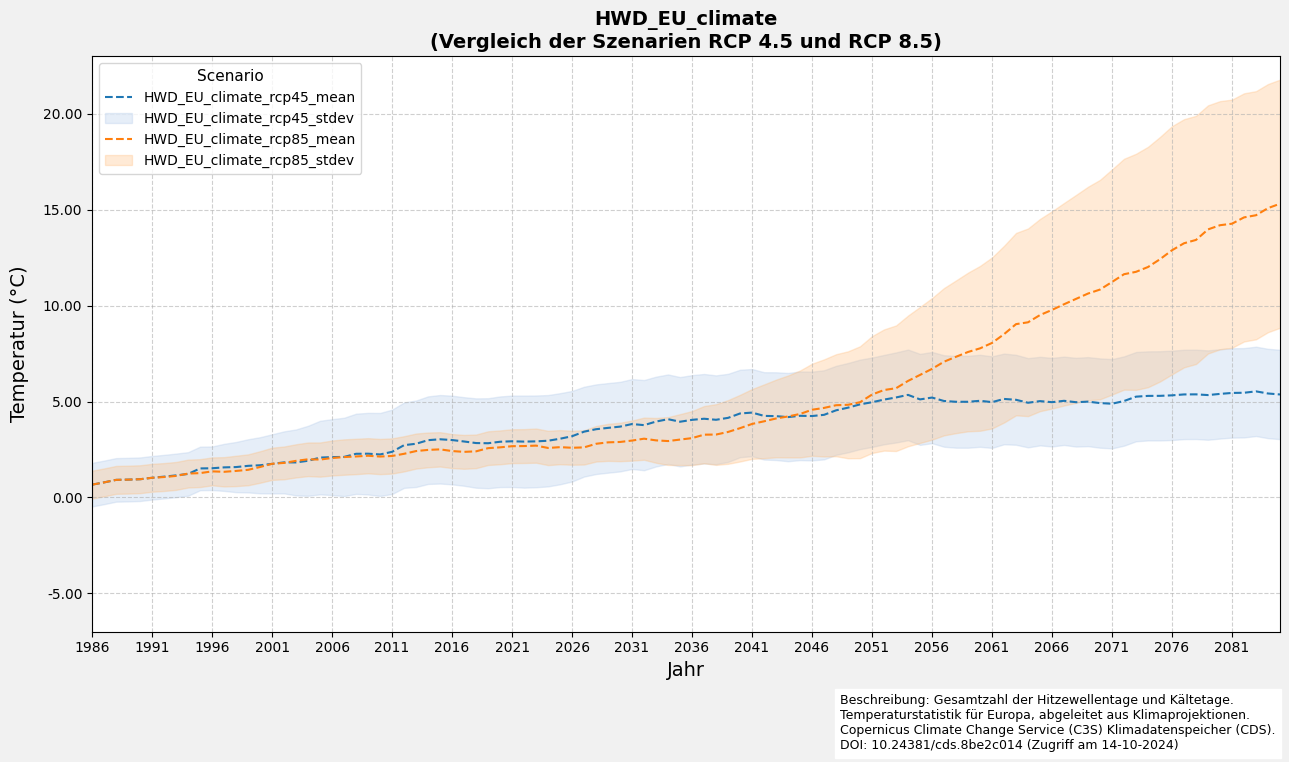

In [19]:
if __name__ == "__main__":
    # Variable des Einzeldatensatzes
    # Dieser Code schlägt für Cold Spell Days fehl, weil die Daten für Konstanz leer sind
    plot_line_and_shade(filtered_df_average=filtered_df_average,
                        variable_name_list=[f"{nc_files[0]['variable_name']}"])

### 6.5 Definieren eine Funktion zur Erstellung einer Heatmap

In [20]:
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import numpy as np

def main_plt_plot(
        nc_file=nc_file,
        selected_year=None,
        bounding_box=None):
    
    # Öffnet die NetCDF-Datei
    nc_dataset = nc.Dataset(nc_file['path'], mode='r')
    lat = nc_dataset.variables['lat'][:]
    lon = nc_dataset.variables['lon'][:]

    # Falls eine Begrenzungsbox angegeben wurde, filtere die Daten entsprechend
    if bounding_box:
        lat_indices = np.where((lat >= bounding_box[1]) & (lat <= bounding_box[3]))[0]
        lon_indices = np.where((lon >= bounding_box[0]) & (lon <= bounding_box[2]))[0]

        lat_subset = lat[lat_indices]
        lon_subset = lon[lon_indices]
    else:
        lat_indices = slice(None)
        lon_indices = slice(None)

        lat_subset = lat
        lon_subset = lon

    # Extrahiere Variablen-Daten
    variable_name = nc_file['variable_name']
    variable_data = nc_dataset.variables[variable_name][..., lat_indices, lon_indices]
    var_units = getattr(nc_dataset.variables[variable_name], "units", "N/A")

    # Bestimmen Sie den Jahresindex auf der Grundlage von selected_year.
    if selected_year < 1986:
        year_index = 0
        year = 1985
    elif selected_year > 2085:
        year_index = -1
        year = 2085
    else:
        year_index = selected_year-1986
        year = selected_year

    # Extrahieren Sie die Daten für das ausgewählte Jahr.
    band_data = variable_data[year_index]

    # NaN-Werte für Perzentilberechnungen entfernen
    band_data_nonan = band_data[~np.isnan(band_data)]
    vmin = np.nanpercentile(band_data_nonan, 1)
    vmax = np.nanpercentile(band_data_nonan, 99)

    def dynamic_round(value):
        # Bestimmen Sie die Größe des Wertes.
        order_of_magnitude = np.floor(np.log10(abs(value)))
        
        # Verwenden Sie diese Größe, um die Genauigkeit dynamisch zu wählen.
        if order_of_magnitude < -2:  # Werte kleiner als 0,01
            return round(value, 3)
        elif order_of_magnitude < -1:  # Werte zwischen 0,01 und 1
            return round(value, 2)
        elif order_of_magnitude < 0:  # Werte zwischen 1 und 10
            return round(value, 1)
        else:  # Werte 10 oder größer
            return round(value)
    
    # Dynamische Rundung auf vmin und vmax anwenden
    vmin = dynamic_round(vmin)
    vmax = dynamic_round(vmax)

    bins = 10
    interval = (vmax - vmin) / bins
    
    # Erstellen Sie ein 2D-Netzgitter für die grafische Darstellung.
    lon_grid, lat_grid = np.meshgrid(lon_subset, lat_subset)

    # Erstelle die Figur
    fig, ax = plt.subplots(
        figsize=(12, 8),
        facecolor='#f1f1f1',
        edgecolor='k',
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # Kartenmerkmale hinzufügen
    ax.coastlines(edgecolor='black', linewidth=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1.5)

    # Erstellen Sie ein Farbnetzdiagramm mit der angegebenen Farbkarte und den Grenzen.
    cmap = plt.get_cmap("viridis", bins)
    pcm = ax.pcolormesh(
        lon_grid,
        lat_grid,
        band_data,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        shading='auto',
        vmin=vmin,
        vmax=vmax,
        )
    
    # Einen Farbbalken hinzufügen
    ticks = np.linspace(vmin, vmax, num=bins + 1)
    cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', pad=0.02, ticks=ticks)
    cbar.set_label(f"{variable_name}", fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    
    # Gitterlinien hinzufügen
    gl = ax.gridlines(draw_labels=True,
                      crs=ccrs.PlateCarree(),
                      linewidth=0.8,
                      color='gray',
                      alpha=0.7,
                      linestyle='--')
    gl.top_labels = False 
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    
    # Titel und Beschriftungen hinzufügen
    fig.text(0.5, 0.0, 'Longitude', ha='center', fontsize=14)
    fig.text(0.06, 0.5, 'Latitude', va='center', rotation='vertical', fontsize=14)
    ax.set_aspect("equal")

    # Einen Titel hinzufügen
    ax.set_title(f"{variable_name}, {year}", fontsize=14)

    # Layout anpassen und das Diagramm anzeigen
    plt.tight_layout()
    plt.show()

### 6.6 Visualisierung mit Heatmap

C:\Users\ShaileshShrestha\anaconda3\envs\cds_env\lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


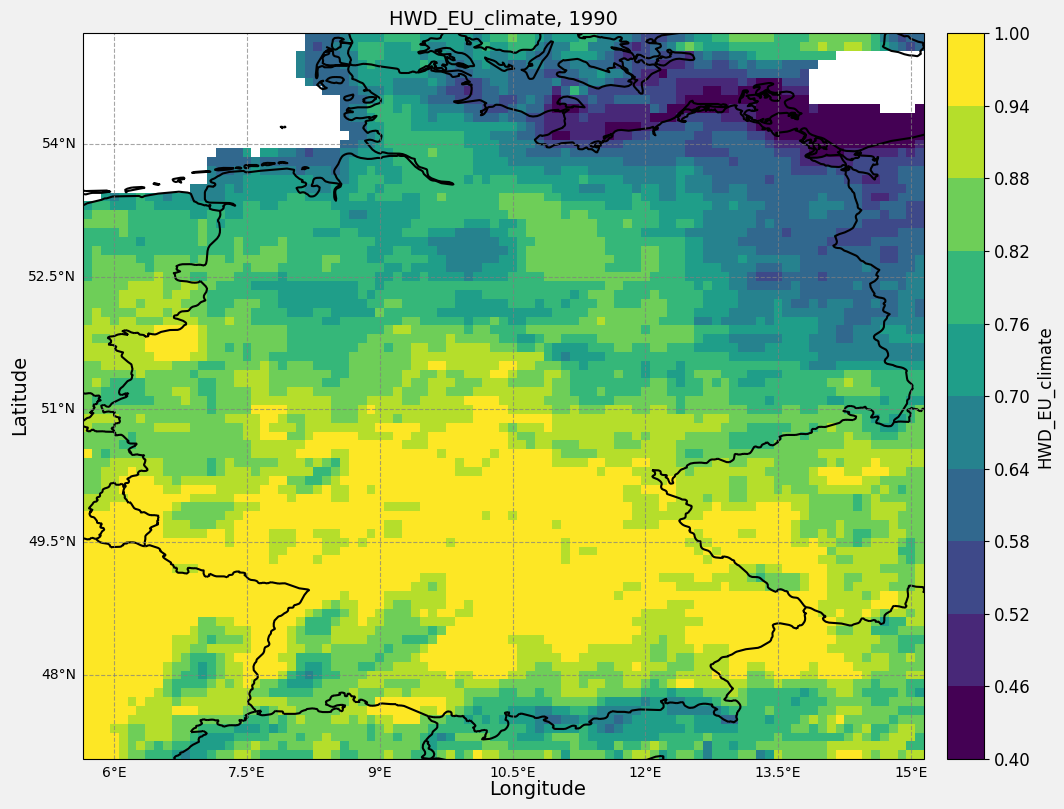

C:\Users\ShaileshShrestha\anaconda3\envs\cds_env\lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


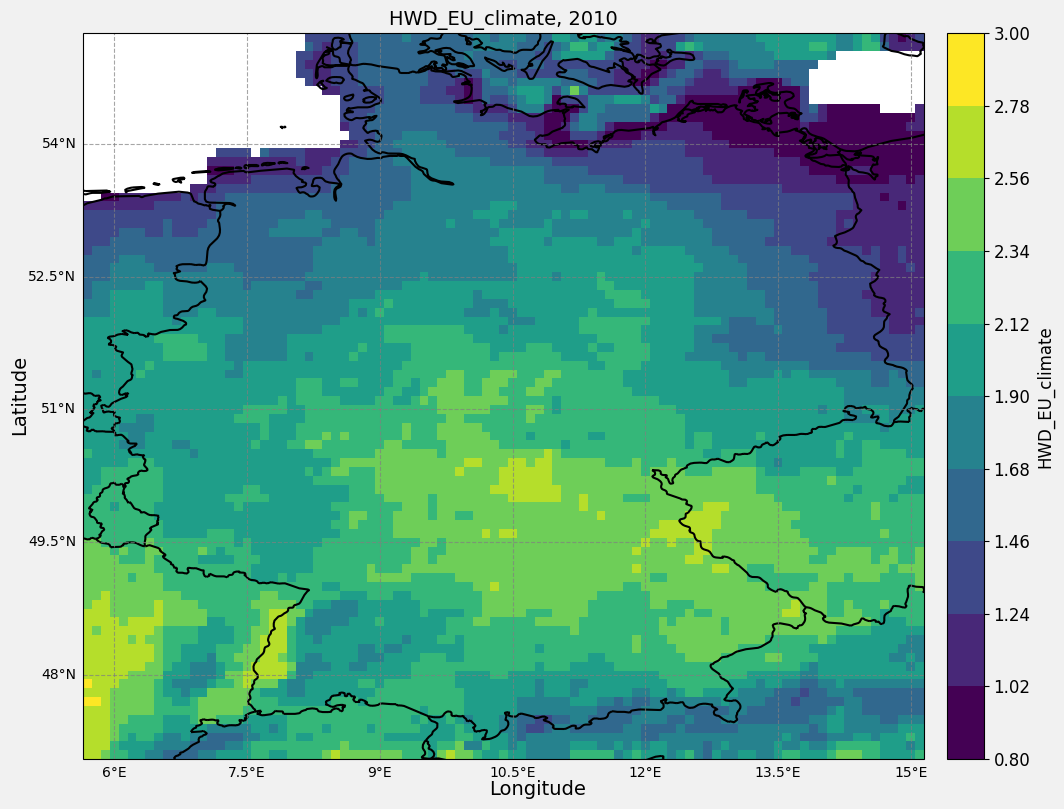

In [21]:
if __name__ == "__main__":
    # Beispiel für einen Anwendungsfall
    main_plt_plot(nc_file=nc_files[0],
                  selected_year=1990,
                  )

    main_plt_plot(nc_file=nc_files[0],
                  selected_year=2010,
                  )